# Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold

# Data Loading

In [56]:
train = pd.read_csv("../project/data/spaceship-titanic/train.csv")
test = pd.read_csv("../project/data/spaceship-titanic/test.csv")
sample_submission = pd.read_csv("../project/data/spaceship-titanic/sample_submission.csv")

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0000,False,0.0000,0.0000,0.0000,0.0000,0.0000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0000,False,109.0000,9.0000,25.0000,549.0000,44.0000,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0000,True,43.0000,3576.0000,0.0000,6715.0000,49.0000,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0000,False,0.0000,1283.0000,371.0000,3329.0000,193.0000,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0000,False,303.0000,70.0000,151.0000,565.0000,2.0000,Willy Santantines,True


**Observation**

* PassengerId : some people came together. We can think family or friends, siblings...
* Cabin : Need to Split('-')
* Shopping~VRDeck : There is a case where only one of the two is counted and it is 0.

In [4]:
train.shape, test.shape

((8693, 14), (4277, 13))

* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage. 
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.0000,8512.0000,8510.0000,8485.0000,8510.0000,8505.0000
mean,28.8279,224.6876,458.0772,173.7292,311.1388,304.8548
std,14.4890,666.7177,1611.4892,604.6965,1136.7055,1145.7172
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,19.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,27.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,38.0000,47.0000,76.0000,27.0000,59.0000,46.0000
max,79.0000,14327.0000,29813.0000,23492.0000,22408.0000,24133.0000


**Observation**
* Age : min이 0인것이 이상하다.

In [7]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

# Preprocessing


In [29]:
train_PassengerId = train['PassengerId']
test_PassengerId = train['PassengerId']

train_Name = train['Name']
test_Name = test["Name"]

In [57]:
# PassengerId를 보면, 같은 그룹으로 온 것을 볼 수 있었다. 구분해서 그 '그룹이 몇명이 왔는지' 새로운 변수 만듦
train.drop(['PassengerId','Name'],axis=1,inplace=True)
test.drop(['PassengerId','Name'],axis=1,inplace=True)

######################################################################
#Split Cabin
# Cabin을 구분해 줄 필요가 있다.
train['Deck'] =train['Cabin'].str.split('/', expand=True)[0]
train['Num'] =train['Cabin'].str.split('/', expand=True)[1]
train['Side'] =train['Cabin'].str.split('/', expand=True)[2]

test['Deck'] =test['Cabin'].str.split('/', expand=True)[0]
test['Num'] =test['Cabin'].str.split('/', expand=True)[1]
test['Side'] =test['Cabin'].str.split('/', expand=True)[2]

#Cabin을 사용하지 않을 것이니 버린다.
#drop Cabin
train.drop(['Cabin'],axis=1, inplace=True)
test.drop(['Cabin'],axis=1, inplace=True)

#to_numeric
train['Num'] = pd.to_numeric(train['Num'])
test['Num'] = pd.to_numeric(test['Num'])

#target 
train['Transported']= train['Transported'].apply(lambda x: 1 if x==True else 0)

#CyroSleep
train['CryoSleep']=train['CryoSleep'].apply(lambda x : 1 if x==True else 0)
test['CryoSleep']=test['CryoSleep'].apply(lambda x : 1 if x==True else 0)

train['VIP']=train['VIP'].apply(lambda x : 1 if x==True else 0)
test['VIP']=test['VIP'].apply(lambda x : 1 if x==True else 0)
#
train.drop(train[train['Age']==0].index, axis=0, inplace=True)
test.drop(test[test['Age']==0].index, axis=0, inplace=True)

# EDA & VIZ

In [42]:
cat_cols = train.select_dtypes(include='object').columns.tolist()
num_cols = train.select_dtypes(exclude='object').columns.tolist()
num_cols.remove('Transported')

<AxesSubplot:xlabel='Transported', ylabel='count'>

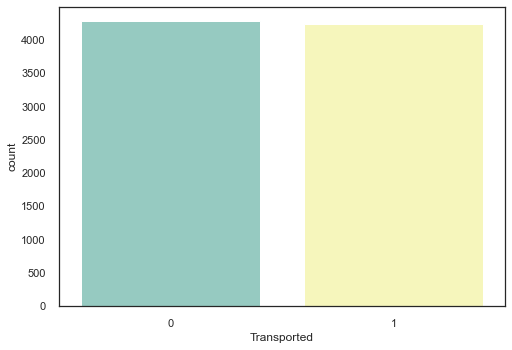

In [23]:
sns.set(style='white')
sns.countplot(train['Transported'],palette='Set3')

<Figure size 576x396 with 0 Axes>

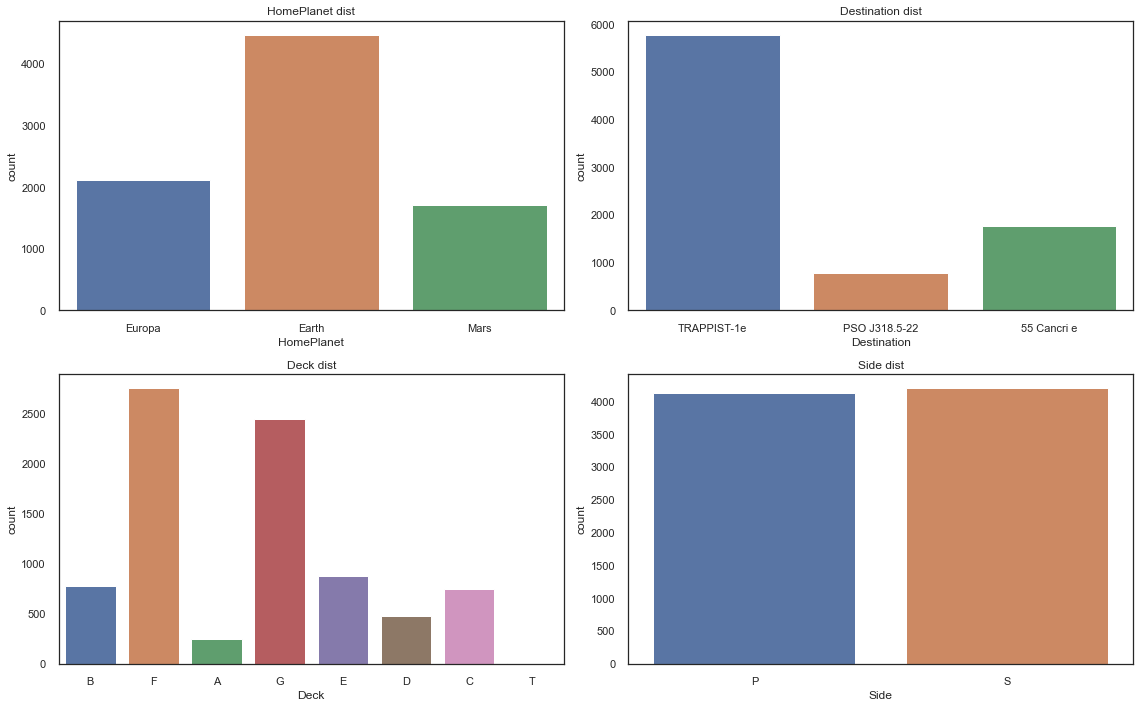

In [24]:
def show_count_plot(df, columns):
    i = 0
    plt.figure()
    plt.subplots(2,2,figsize=(16,10))
    for column in columns:
        i +=1
        plt.subplot(2,2,i)
        sns.countplot(df[column])
        plt.title(f'{column} dist')
    plt.tight_layout()
        
        
show_count_plot(train, cat_cols)

**Observation**

* 지구에 거주하는 사람들이 많다.
* VIP를 일부만 사용했다.
* 일부 다른 목적지로 향했다.
* Deck에는 F,G에 대부분 착석했다.
* Side에는 큰 차이가 보이지 않는다.

<Figure size 864x216 with 0 Axes>

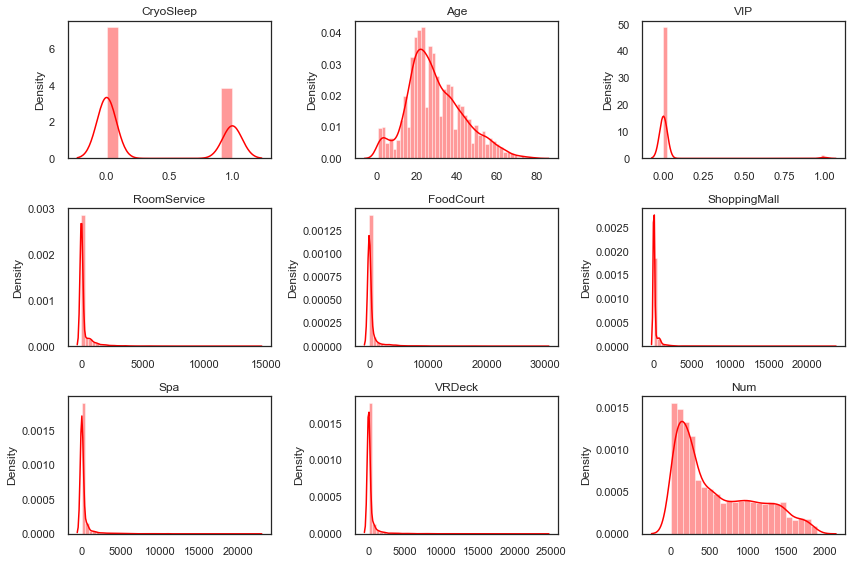

In [259]:
def show_dist_plot(df,columns):
    i = 0
    plt.figure(figsize=(12,3))
    f,ax=plt.subplots(3,3,figsize=(12,8))
    for column in columns:
        i += 1
        plt.subplot(3,3,i)
        sns.distplot(x=df[column],kde=True,color='Red')
        plt.title("{}".format(column))
    plt.tight_layout();
        
show_dist_plot(train, num_cols)

**Observation**

* Age에 0살이 있다.
* 일부만 편의시설을 사용했다. 
* Num 변수에 정규화가 필요함.

<Figure size 864x216 with 0 Axes>

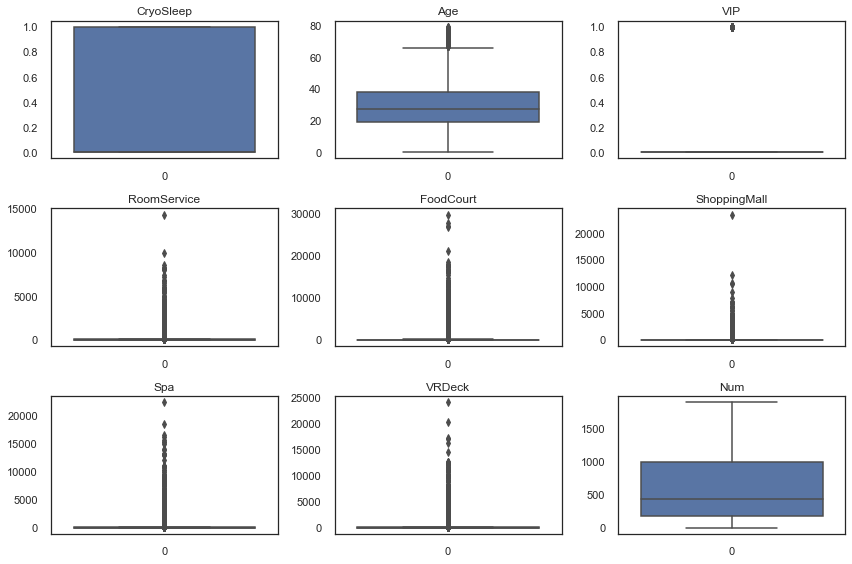

In [72]:
def show_dist_plot(df,columns):
    i = 0
    plt.figure(figsize=(12,3))
    f,ax=plt.subplots(3,3,figsize=(12,8))
    for column in columns:
        i += 1
        plt.subplot(3,3,i)
        sns.boxplot(data=df[column])
        plt.title("{}".format(column))
    plt.tight_layout();
        
show_dist_plot(train, num_cols)

<AxesSubplot:>

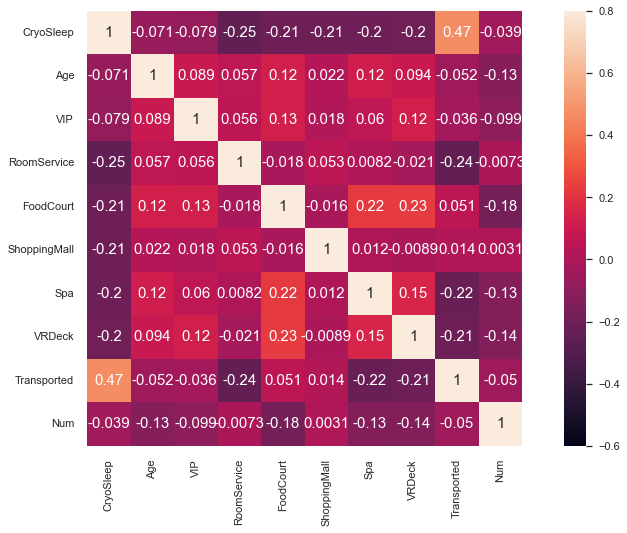

In [25]:
plt.figure(figsize=(15,8))
sns.heatmap(train.corr(),annot=True, vmin=-0.6, vmax=.8, square=True, annot_kws={'size':15})

<Figure size 576x396 with 0 Axes>

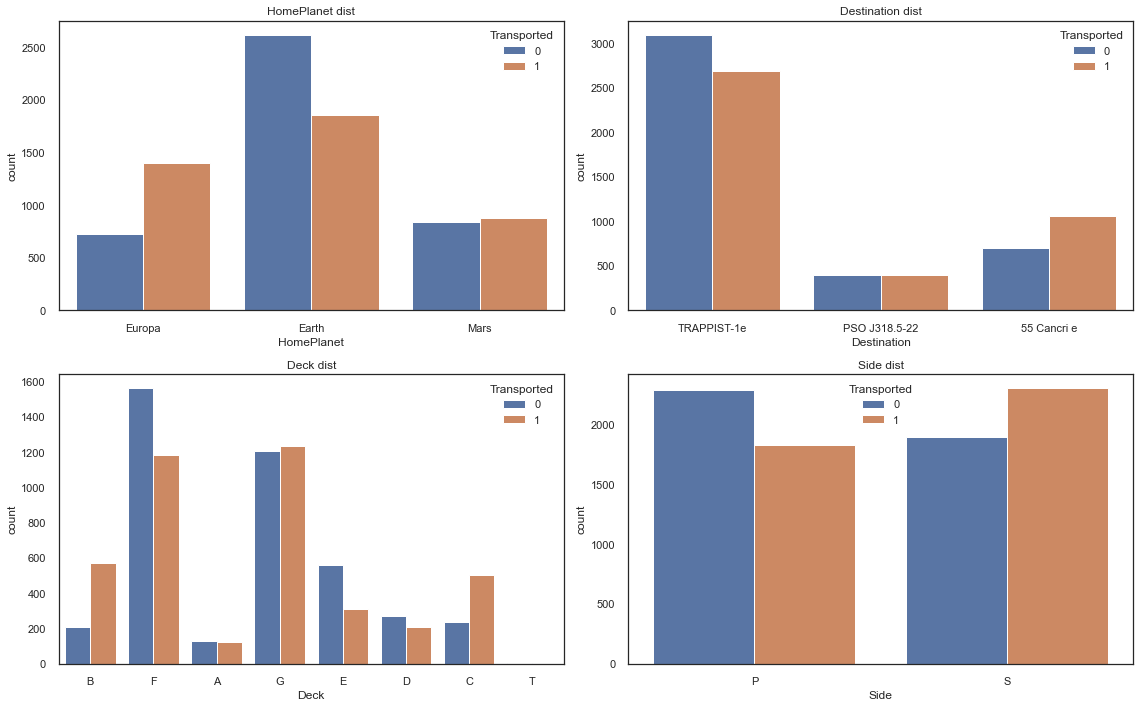

In [26]:
def show_swarm_plot(data, columns):
    i = 0
    plt.figure()
    plt.subplots(2,2,figsize=(16,10))
    for column in columns:
        i +=1
        plt.subplot(2,2,i)
        sns.countplot(data[column],hue=data['Transported'],dodge=True)
        plt.title(f'{column} dist')
    plt.tight_layout()
    
show_swarm_plot(train, cat_cols)

**Observation**

* 화성과 Europa 에서 출발한 로켓은 잘 도착했다만, 지구에서 출발한 이는 잘 도착하지 않았다.
* 여행 도중 애니메이션을 키고 간 사람들은 잘 도착했다. 아마 지침에 대한 애니메이션이지 않았을까 싶다.
* Side가 P이면 잘 도착하지 않았음을 보여준다.

(-100.0, 15000.0)

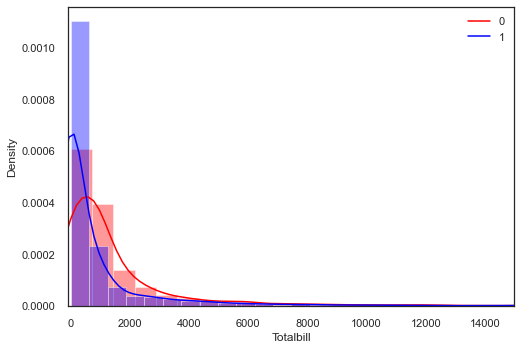

In [393]:
#Total bill & Transported

f,ax=plt.subplots(1,1)
sns.distplot(train[train['Transported']==0]['Totalbill'],color='red')
sns.distplot(train[train['Transported']==1]['Totalbill'],color='blue')
plt.legend(['0','1'])
plt.xlim(-100,15000)


**Observation**

* 편의시설에 사용을 많이 한 사람들이 목적지에 잘 도착했다.
    * VIP와 관련이 있지 않을까?

(-100.0, 15000.0)

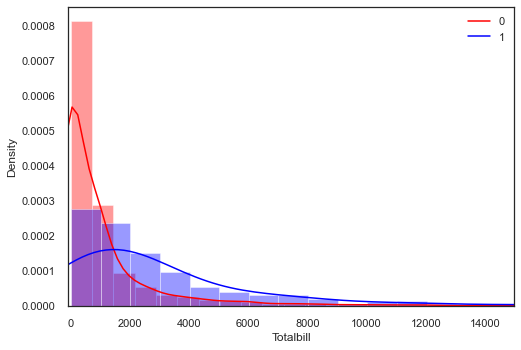

In [394]:
#VIP인 사람들은 편의시설을 많이 사용했을까?
#Total bill & Transported

f,ax=plt.subplots(1,1)
sns.distplot(train[train['VIP']==0]['Totalbill'],color='red')
sns.distplot(train[train['VIP']==1]['Totalbill'],color='blue')
plt.legend(['0','1'])
plt.xlim(-100,15000)

**Obseravtion**

* VIP인 사람들이 편의시설을 많이 사용했다.

# Feature Engineering

In [58]:
train['Name'] = train_Name
test['Name'] = test_Name

train['PassengerId'] = train_PassengerId
test['PassengerId'] = test_PassengerId

bill = train.columns[5:10].tolist()
train['Totalbill']=np.sum(train[bill],axis=1)
test['Totalbill']=np.sum(test[bill],axis=1)

def bill_ratio(df):
    df['RoomService_ratio'] = df['RoomService']/df['Totalbill']
    df['FoodCourt_ratio'] = df['FoodCourt']/df['Totalbill']
    df['ShoppingMall_ratio'] = df['ShoppingMall']/df['Totalbill']
    df['Spa_ratio'] = df['Spa']/df['Totalbill']
    df['VRDeck_ratio'] = df['VRDeck']/df['Totalbill']

    return df
    
train = bill_ratio(train)
test = bill_ratio(test)

#Familysize
train['PassengerGroup']=train['PassengerId'].apply(lambda x: str(x[:4])).astype('int')
test['PassengerGroup']=test['PassengerId'].apply(lambda x: str(x[:4])).astype('int')

train['PassengerNum'] = train['PassengerId'].apply(lambda x : x[-2:]).astype('int')
test['PassengerNum'] = test['PassengerId'].apply(lambda x : x[-2:]).astype('int')

#groupsize
train['GroupSize']=train.groupby(['PassengerGroup'])['PassengerNum'].transform('max').astype('int')
test['GroupSize']=test.groupby(['PassengerGroup'])['PassengerNum'].transform('max').astype('int')

#drop
train.drop(['PassengerId','Name'],axis=1, inplace=True)
test.drop(['PassengerId','Name'],axis=1, inplace=True)

# Modeling

In [49]:
# train =pd.get_dummies(train)
# test = pd.get_dummies(test)

In [59]:
X = train.drop(['Transported'],axis=1)
y = train.Transported

X_train,X_test,y_train,y_test= train_test_split(X,y, test_size=.3, random_state=42)

In [52]:
# from lightgbm import LGBMClassifier
# clf = LGBMClassifier()
# clf.fit(X_train, y_train)
# pred = clf.predict(X_test)
# print(clf.score(X_test,y_test))

0.8148727984344423


In [60]:
from pycaret.classification import *

exp_101 = setup(data=train, target='Transported',session_id=123, fold_shuffle=True, n_jobs=-1)

,Description,Value
0,session_id,123
1,Target,Transported
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(8515, 23)"
5,Missing Values,1
6,Numeric Features,14
7,Categorical Features,8
8,Ordinal Features,0
9,High Cardinality Features,0


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

# Feature Importance

In [86]:
#catboost가 높은 Accuracy를 보여주고 있으니 하나를 잡아서 진행한다.

cbt = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8221,0.9063,0.8209,0.8209,0.8209,0.6443,0.6443
1,0.8003,0.8932,0.7905,0.8041,0.7973,0.6006,0.6007
2,0.8054,0.9012,0.7703,0.8261,0.7972,0.6105,0.6119
3,0.7852,0.8797,0.7872,0.7819,0.7845,0.5705,0.5705
4,0.8322,0.9146,0.8378,0.8267,0.8322,0.6644,0.6645
5,0.8188,0.9181,0.8243,0.8133,0.8188,0.6376,0.6377
6,0.8054,0.9043,0.8007,0.8061,0.8034,0.6107,0.6107
7,0.7987,0.8948,0.7939,0.7993,0.7966,0.5973,0.5973
8,0.8188,0.9174,0.8519,0.7981,0.8241,0.6377,0.6391
9,0.8289,0.9021,0.8081,0.8421,0.8247,0.6577,0.6582


In [87]:
tuned_model = tune_model(cbt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8289,0.9088,0.8378,0.8212,0.8294,0.6577,0.6579
1,0.7919,0.8937,0.8041,0.7829,0.7933,0.5839,0.5842
2,0.8070,0.8967,0.7973,0.8110,0.8041,0.6140,0.6141
3,0.7836,0.8812,0.7905,0.7774,0.7839,0.5671,0.5672
4,0.8205,0.9059,0.8446,0.8039,0.8237,0.6410,0.6419
5,0.8171,0.9108,0.8378,0.8026,0.8198,0.6343,0.6349
6,0.8154,0.9065,0.8345,0.8019,0.8179,0.6310,0.6315
7,0.8054,0.8973,0.8142,0.7980,0.8060,0.6108,0.6109
8,0.8238,0.9138,0.8687,0.7963,0.8309,0.6478,0.6504
9,0.7970,0.8938,0.7912,0.7993,0.7953,0.5939,0.5940


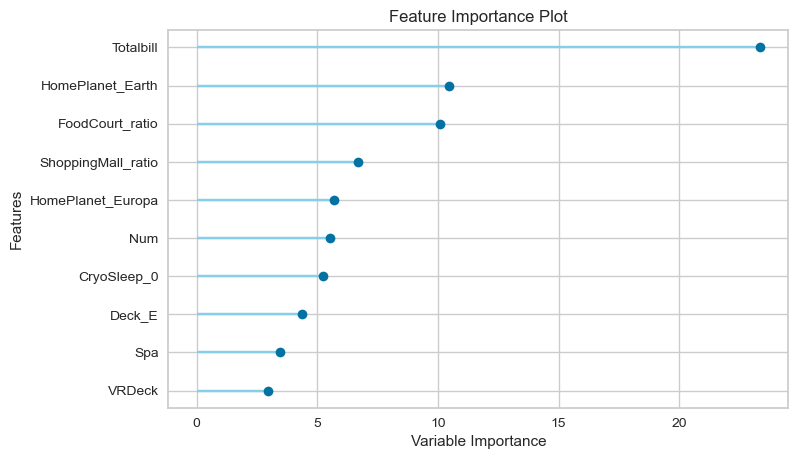

In [97]:
plot_model(tuned_model,plot='feature')

In [95]:
sample_submission['Transported'] = pred['Label']
sample_submission['Transported']= sample_submission['Transported'].apply(lambda x: False if x==0 else True)
sample_submission.to_csv("./data/spaceship-titanic/submission.csv", index=False)

# 마무리

3개의 행성에서 출발한 로켓이 목적행성에 잘 도착했는지에 대한 분류를 목적으로 한 분석이다.

EDA, Feature Engineering을 한 후, Catboost 모델로 살펴보았다. (최종본은 앙상블 모델로 진행하였다.)

* 잘 도착했는지 안했는지 Totalbill이 중요한 변수라고 말한다.